In [2]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Replace 'dataset.zip' with the actual path if it’s in a subfolder
zip_path = '/content/drive/MyDrive/archive8.zip'
extract_path = '/content'  # Extract to /content so the full path is accessible

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify that the folders are there
print(os.listdir(extract_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.config', 'archive8', 'drive', '__MACOSX', 'sample_data']


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

# Define dataset path
dataset_path = "/content/archive8/images/images"

# Data Generator for loading and preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Load dataset from directories
data = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Resize images to 224x224 (VGG16 input size)
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    shuffle=True
)

# Extract data and labels
images, labels = [], []
for i in range(len(data)):
    x, y = data[i]
    images.append(x)
    labels.append(y)
    if len(images) * data.batch_size >= data.n:  # Stop when all data is loaded
        break

images = np.vstack(images)  # Combine into a single numpy array
labels = np.vstack(labels)


Found 900 images belonging to 10 classes.


In [4]:
# Load the pretrained VGG16 model (excluding the top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define the feature extractor model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
features = feature_extractor.predict(images)
features = features.reshape(features.shape[0], -1)  # Flatten the features


29/29 ━━━━━━━━━━━━━━━━━━━━ 596s 21s/step


In [5]:
# Convert one-hot encoded labels to class indices
labels = np.argmax(labels, axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize


In [12]:
# Create the CNN model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(len(np.unique(labels)), activation='softmax'))  # Output layer with softmax for multi-class classification

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Train the model
history = model.fit(images, labels, epochs=10, batch_size=32, validation_split=0.2, verbose=2)


Epoch 1/10
23/23 - 93s - 4s/step - accuracy: 0.1556 - loss: 2.2758 - val_accuracy: 0.2556 - val_loss: 2.1479
Epoch 2/10
23/23 - 98s - 4s/step - accuracy: 0.2819 - loss: 2.0464 - val_accuracy: 0.3167 - val_loss: 1.8939
Epoch 3/10
23/23 - 137s - 6s/step - accuracy: 0.3903 - loss: 1.7405 - val_accuracy: 0.4833 - val_loss: 1.6971
Epoch 4/10
23/23 - 144s - 6s/step - accuracy: 0.5361 - loss: 1.3815 - val_accuracy: 0.4111 - val_loss: 1.7912
Epoch 5/10
23/23 - 140s - 6s/step - accuracy: 0.6375 - loss: 1.1222 - val_accuracy: 0.5722 - val_loss: 1.3274
Epoch 6/10
23/23 - 147s - 6s/step - accuracy: 0.7278 - loss: 0.8291 - val_accuracy: 0.5722 - val_loss: 1.3783
Epoch 7/10
23/23 - 91s - 4s/step - accuracy: 0.8056 - loss: 0.6447 - val_accuracy: 0.6111 - val_loss: 1.6011
Epoch 8/10
23/23 - 144s - 6s/step - accuracy: 0.8306 - loss: 0.4950 - val_accuracy: 0.6000 - val_loss: 1.5384
Epoch 9/10
23/23 - 95s - 4s/step - accuracy: 0.8708 - loss: 0.4191 - val_accuracy: 0.6444 - val_loss: 1.5628
Epoch 10/10
23

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 884ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        19
           1       0.95      0.95      0.95        20
           2       1.00      0.94      0.97        16
           3       1.00      0.82      0.90        22
           4       1.00      0.88      0.94        17
           5       0.71      0.83      0.77        18
           6       0.84      0.94      0.89        17
           7       0.88      0.88      0.88        16
           8       0.92      0.79      0.85        14
           9       0.91      0.95      0.93        21

    accuracy                           0.89       180
   macro avg       0.90      0.89      0.89       180
weighted avg       0.90      0.89      0.90       180



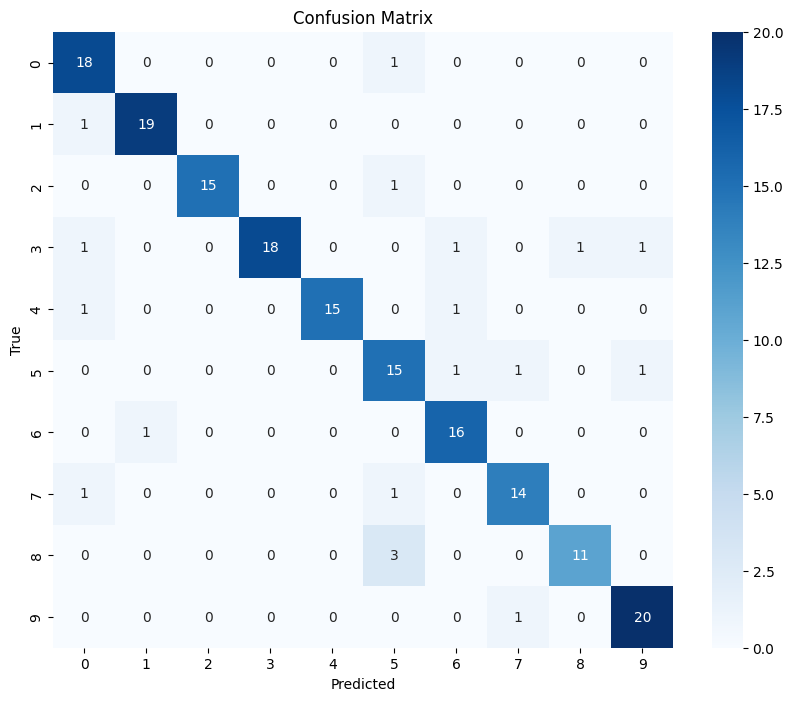

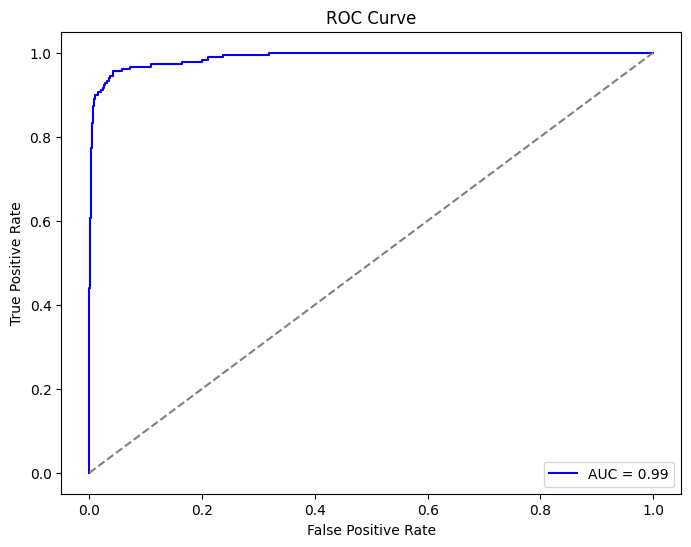

In [15]:
# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve for each class
y_test_bin = label_binarize(y_test, classes=np.unique(labels))  # One-hot encoding for ROC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
